In [1]:
#라이브러리 import
import pandas as pd 
from pandas import ExcelWriter
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [3]:
# 좌표 추출 및 이상 군집 제거 함수

# 좌표 추출 함수
def Get_Cordinate(img_gray, img_name, filter_num):
    
    #이미  이미지를 gray모드로 가져옴
    #이미지를 필터링, 필터링하는 이유는 십자 붉은 선을 없애주기 위함
    ret, thr1 = cv.threshold(img_gray, filter_num, 255, cv.THRESH_BINARY) 
    temp = np.where(thr1 == 255)
    
    #RawData에 필터링 된 픽셀 좌표값 입력(pandas DataFrame)
    df_RawData = pd.DataFrame(columns = ['x', 'y'])
    df_RawData.x = temp[1]
    df_RawData.y = temp[0]
    
    #필터링 값을 증가시키면서 붉은 십자선 및 잔상을 없애줌, 필터린 된 값의 y축의 최소값이 0이면 붉은 십자선 남아있다고 판단
    while min(df_RawData.y)==0:
        filter_num += 1
        ret, thr1 = cv.threshold(img_gray, filter_num, 255, cv.THRESH_BINARY)
        temp = np.where(thr1 == 255)
        df_RawData = pd.DataFrame(columns = ['x', 'y'])
        df_RawData.x = temp[1]
        df_RawData.y = temp[0]
    
    #DBSCAN (밀도기반 클러스터링)
    temp = df_RawData.reset_index().values
    df_DBSCAN_data = temp[:,1:3]
    model = DBSCAN()
    y_predict = model.fit_predict(df_DBSCAN_data)
    
     #한 점으로 부터 특정거리(eps) 반경 내에 점의 수(min_sample)이 몇개인가를 기준으로 군집 판단 
    Clusters = DBSCAN(eps=5, min_samples=10).fit(df_DBSCAN_data)
    
    #군집 라벨링
    df_Cluster_Data = df_RawData
    df_Cluster_Data['id'] = Clusters.labels_
    df_Cluster_Data = df_Cluster_Data.sort_values('id', ascending = True) #id 기준으로 오름차순 정렬
    
    #군집의 크기 측정
    temp = []
    for i in range(0,max(df_Cluster_Data.id) + 1):
        temp.append([i,len(df_Cluster_Data[df_Cluster_Data.id == i])])
        df_CheckData = pd.DataFrame(temp,columns=('id','length'))
     
    #점이 1개인 이미지  
    if max(df_CheckData.id) == 0:
        Option = [1, 1]
        #좌표 측정
        df_Cluster_Data = df_Cluster_Data[df_Cluster_Data.id == 0]
        df_Cordinate_data = df_Cluster_Data.pivot_table(values = ['x','y'], index = 'id', aggfunc = 'mean')
        df_Cordinate_data = round(df_Cordinate_data)
        df_Cordinate_data = df_Cordinate_data.reset_index(drop=True)  
        
    #사각형이 없는 21*9 이미지    
    elif max(df_CheckData.id) == 188:
        Option = [21, 9]
        #좌표 측정
        df_Cordinate_data = df_Cluster_Data.pivot_table(values = ['x','y'], index = 'id', aggfunc = 'mean')
        df_Cordinate_data = round(df_Cordinate_data)
        df_Cordinate_data = df_Cordinate_data.reset_index(drop=True)
        
    #사각형이 없는 15*5 이미지     
    elif max(df_CheckData.id) == 74:
        Option = [15, 5] 
        #좌표 측정
        df_Cordinate_data = df_Cluster_Data.pivot_table(values = ['x','y'], index = 'id', aggfunc = 'mean')
        df_Cordinate_data = round(df_Cordinate_data)
        df_Cordinate_data = df_Cordinate_data.reset_index(drop=True)
        
    #점이 21*9이면서 사각형이 있는 이미지 
    elif max(df_CheckData.id) > 188:
        Option = [21, 9] 
        #최소사이즈의 군집보다 5배 이상 사이즈를 가지는(사각형) 군집을 제거
        min_length = min(df_CheckData.length)  
        df_CheckData['remove'] = df_CheckData.apply(lambda x: remove_id(x['length'],min_length),axis = 1)
        
        for i in range(0,max(df_Cluster_Data.id) + 1):
            if df_CheckData.remove[i] == 1: 
                df_Cluster_Data = df_Cluster_Data.drop(df_Cluster_Data[df_Cluster_Data.id == i].index)
        
        #좌표 측정
        df_Cordinate_data = df_Cluster_Data.pivot_table(values = ['x','y'], index = 'id', aggfunc = 'mean')
        df_Cordinate_data = round(df_Cordinate_data)
        df_Cordinate_data = df_Cordinate_data.reset_index(drop=True)
        
    #사각형이 없는 15*5 이미지     
    else:
        Option = [1, max(df_CheckData.id)]  
        #좌표 측정
        df_Cordinate_data = df_Cluster_Data.pivot_table(values = ['x','y'], index = 'id', aggfunc = 'mean')
        df_Cordinate_data = round(df_Cordinate_data)
        df_Cordinate_data = df_Cordinate_data.reset_index(drop=True)
    
    
    #dot을 이미지 위에 표시
    plt.figure(figsize = (20,10))
    plt.ylim([max(df_RawData.y)+30,min(df_RawData.y)-30])
    plt.xlim([min(df_RawData.x)-30,max(df_RawData.x)+30])
    #plt.imshow(img_gray, cmap = 'gray')
    plt.imshow(img_gray, cmap = 'gray')
    
    for n in range(len(df_Cordinate_data)):
        x = int(df_Cordinate_data.x[n])
        y = int(df_Cordinate_data.y[n])
        plt.scatter(x, y, marker = '.', s = 20, color = 'r')
        plt.text(x+5, y+10, "{},\n{}".format(x,y), fontsize = 10, color = 'w')
        
    plt.savefig('좌표_%s'%img_name)
    
    df_Cordinate_data = df_Cordinate_data.sort_values('x', ascending = True)
    df_Export_data = df_Cordinate_data.reset_index()
    df_Export_data = df_Export_data.drop('index', axis = 1)
    i = 0
    df_Excel_output = pd.DataFrame()
    
    while i < Option[0]:
        temp = df_Export_data.iloc[i*Option[1]:(i+1)*Option[1]]
        temp = temp.sort_values('y', ascending = True)
        temp['seq'] = list(range(1,(Option[1]+1)))
        temp.set_index(temp.seq, inplace = True)
        temp = temp.drop('seq', axis = 1)
        df_Excel_output = pd.concat([df_Excel_output,temp], axis = 1)
        i += 1
        
    return df_Excel_output

# 최소군집의 크기의 3배 이상인 군집들을 이상 군집이라 판단 (제거 대상)
def remove_id(x_length, minlength):
    if x_length/minlength > 3: 
        num = 1
    else:
        num = 0
    return num

# ※ 대상 이미지 선택 및 좌표 추출 실행

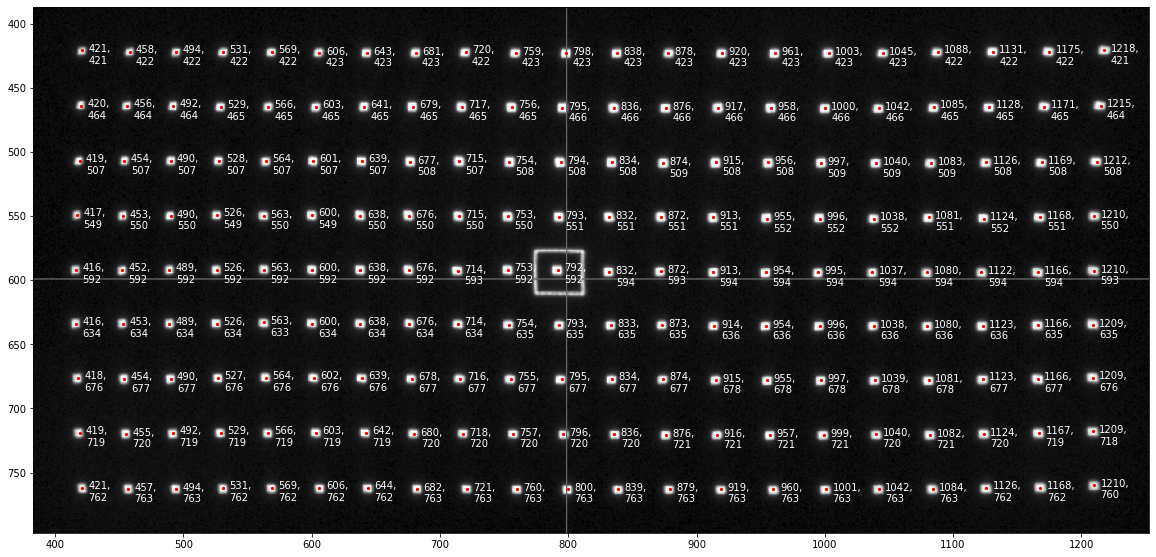

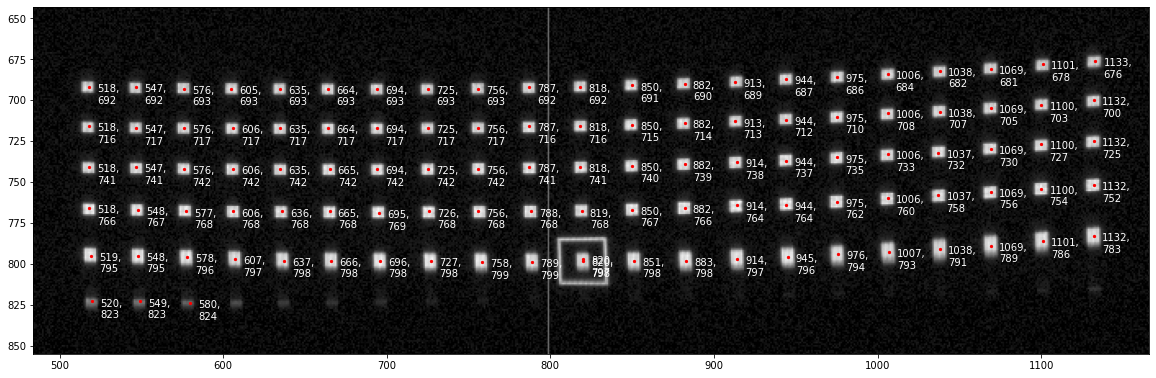

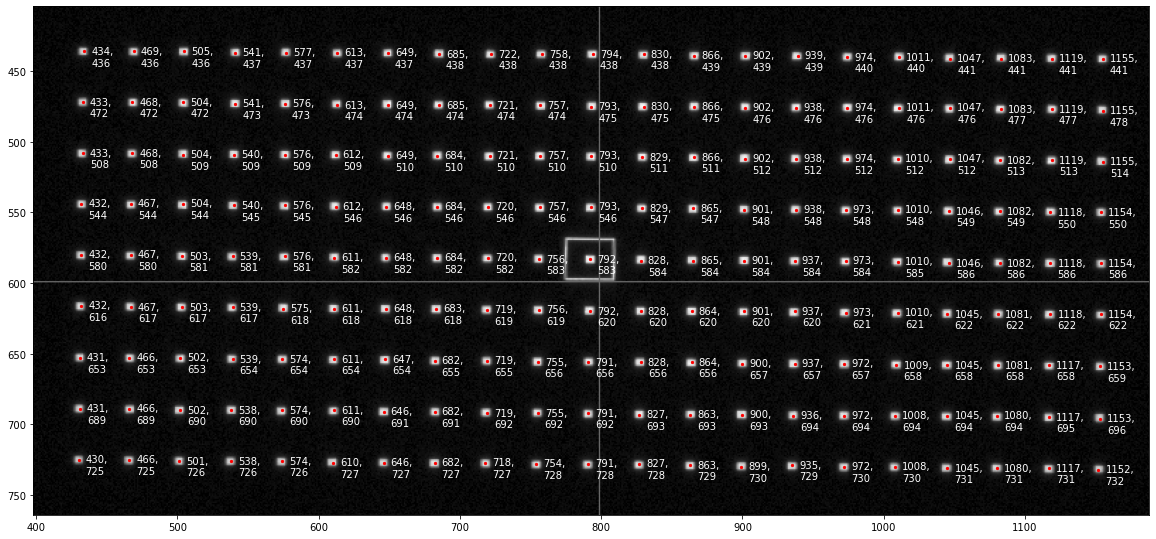

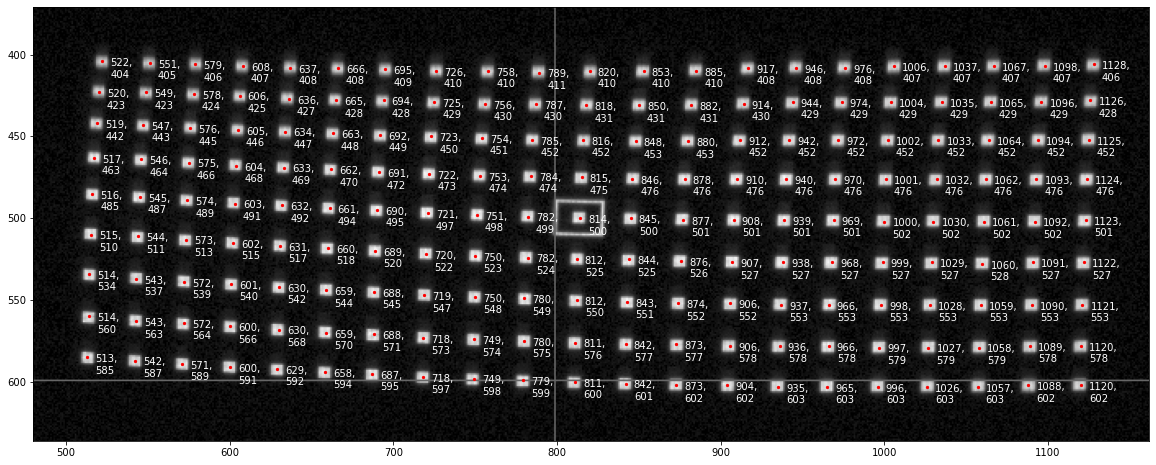

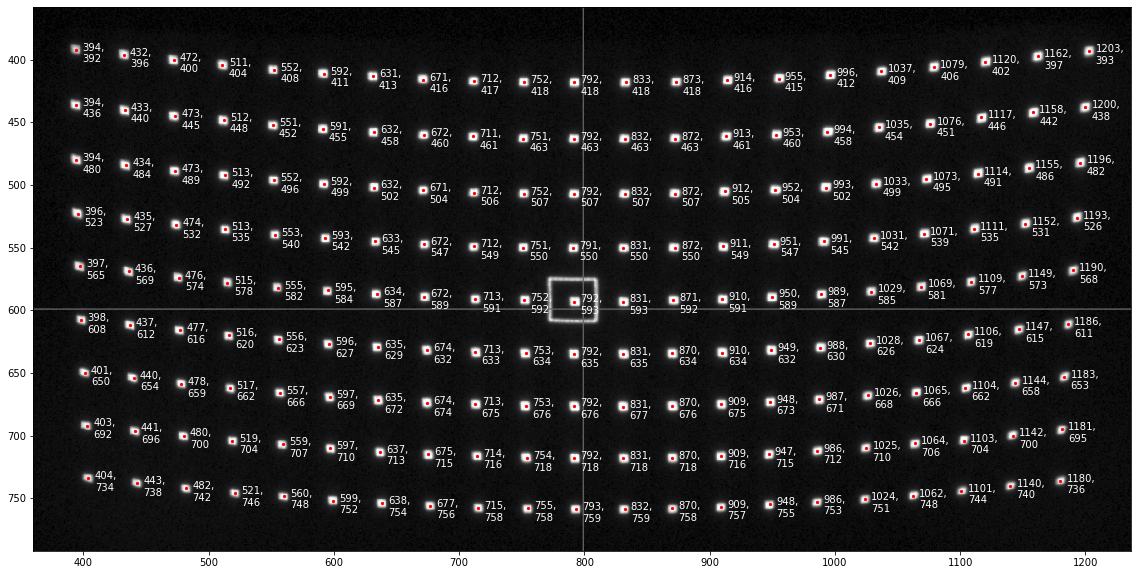

In [4]:
#이미지파일 명, 필터링 값 입력
# ---------------------------------------------------------------- img_names만 설정하면 됨 (21*9, 17*5 그림 상관없음,이외 엑셀 추출 에러 발생)

img_names = ['1.png','2.png','3.png','4.png','5.png']

# ---------------------------------------------------------------- 아래 부분 설정 불필요
filter_num = 50 #필터링 50~255 사이
writer = ExcelWriter('./좌표_output.xlsx')

for temp in img_names:
    img_read = cv.imread('%s'%temp,cv.IMREAD_GRAYSCALE)
    output = Get_Cordinate(img_read, temp, filter_num)
    output.to_excel(writer,'%s'%temp)

writer.save()